In [1]:
import os
import json
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight

import av  # pip install av
from transformers import (
    AutoImageProcessor,
    VideoMAEForVideoClassification,
    TrainingArguments,
    Trainer,
)

import evaluate  # pip install evaluate

# load environment variables with dotenv
from dotenv import load_dotenv
load_dotenv()


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
from train import *
import os


In [3]:
# Point this at the Olympic Boxing dataset directory
DATASET_DIR = "Olympic Boxing Punch Classification Video Dataset"

# Pretrained VideoMAE base (self-supervised on K400)
model_name = "MCG-NJU/videomae-base"

image_processor = AutoImageProcessor.from_pretrained(model_name)
model = VideoMAEForVideoClassification.from_pretrained(
    model_name,
    num_labels=len(LABEL2ID),
    label2id=LABEL2ID,
    id2label=ID2LABEL,
)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# check for cuda
if torch.cuda.is_available():
    model.to("cuda")
    print("Using CUDA")
else:
    print("Using CPU")

Using CUDA


In [5]:
train_dataset = BoxingDataset(
    split="train",
)
val_dataset = BoxingDataset(
    split="val",
)
test_dataset = BoxingDataset(
    split="test",
)

In [6]:

# FACTS used batch_size=4, grad_accum=2, warmup_ratio=0.1, epochs=10
# Learning rate is not rendered in the HTML; start with 1e-4 and tune around it.
training_args = TrainingArguments(
    output_dir="./facts-boxing-videomae",
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    save_total_limit=2,
    num_train_epochs=10,
    per_device_train_batch_size=4, 
    per_device_eval_batch_size=8, 
    gradient_accumulation_steps=2,  # effective batch size 8
    warmup_ratio=0.1,
    learning_rate=1e-4,
    weight_decay=0.05,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="wandb",  # or "wandb"/"tensorboard"
    dataloader_num_workers=4,        # ADD THIS - use multiple workers
    dataloader_pin_memory=True,      # ADD THIS - faster CPU->GPU transfer
    dataloader_prefetch_factor=2, 
)

data_collator = VideoDataCollator()

train_labels = [LABEL2ID[path.split("/")[-2]] for path in BoxingDataset.train_paths]

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.arange(len(LABEL2ID)),
#     y=np.array(train_labels)  # Ensure it's a numpy array
# )
# class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [7]:
class_counts = np.bincount(train_labels)
sample_weights = 1.0 / class_counts[train_labels]

sampler = torch.utils.data.WeightedRandomSampler(
    sample_weights,                                              
    len(sample_weights), 
    replacement=True
)
sampler


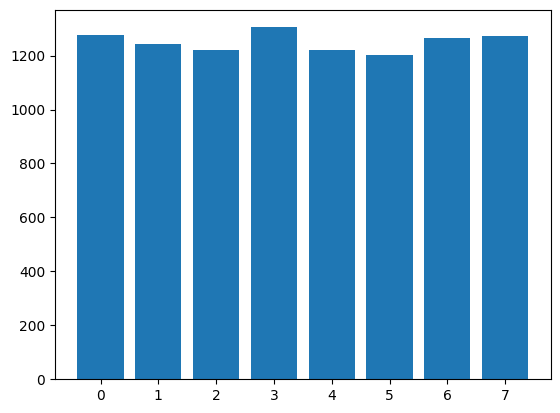

In [8]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict

sample_counts = defaultdict(int)
for i in range(10000):
    sampled_idx = random.choices(train_labels, weights=sample_weights, k=1)[0]
    sample_counts[sampled_idx] += 1

# use matplotlib to plot the distribution

plt.bar(sample_counts.keys(), sample_counts.values())
plt.show()

In [9]:
class UniformSamplerTrainer(Trainer):
    def __init__(self, *args, train_sampler=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_sampler = train_sampler
        
    def _get_train_sampler(self, train_dataset: Dataset | None = None):
        if train_dataset is None:
            train_dataset = self.train_dataset
            
        if train_dataset is None or not has_length(train_dataset):
            return None
        
        if self.train_sampler is not None:
            return self.train_sampler
        
        return super()._get_train_sampler(train_dataset)

trainer = UniformSamplerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_sampler=sampler,
)


In [ ]:
os.environ["WANDB_NAME"] = "Balanced Sampling - 10 Epochs"

# Train
trainer.train()


wandb: Currently logged in as: nkosik11 (nkosik11-hobby) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Lhhp,Precision Lhhp,Recall Lhhp,F1 Rhhp,Precision Rhhp,Recall Rhhp,F1 Lhmp,Precision Lhmp,Recall Lhmp,F1 Rhmp,Precision Rhmp,Recall Rhmp,F1 Lhblp,Precision Lhblp,Recall Lhblp,F1 Rhblp,Precision Rhblp,Recall Rhblp,F1 Lhbp,Precision Lhbp,Recall Lhbp,F1 Rhbp,Precision Rhbp,Recall Rhbp
500,2.100200,2.108851,0.037199,0.008966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071730,0.037199,1.000000
1000,2.056600,2.675185,0.032823,0.011261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.033333,0.022727,0.000000,0.000000,0.000000,0.063063,0.032787,0.823529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1500,2.063100,2.205578,0.024070,0.016342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045113,0.033708,0.068182,0.048780,0.200000,0.027778,0.036842,0.019284,0.411765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000,1.974900,2.770916,0.045952,0.011488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091904,0.049881,0.583333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2500,1.839800,2.594917,0.041575,0.051176,0.000000,0.000000,0.000000,0.177419,0.268293,0.132530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027907,0.016760,0.083333,0.204082,0.156250,0.294118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3000,1.598900,3.489387,0.056893,0.050447,0.000000,0.000000,0.000000,0.043011,0.200000,0.024096,0.094118,0.333333,0.054795,0.000000,0.000000,0.000000,0.121212,0.074074,0.333333,0.095238,0.080000,0.117647,0.000000,0.000000,0.000000,0.050000,0.026906,0.352941


In [ ]:

# Evaluate on test split
test_metrics = trainer.evaluate(test_dataset)
print("Test metrics:", test_metrics)


Test metrics: {'eval_loss': 4.940603733062744, 'eval_accuracy': 0.3169164882226981, 'eval_macro_f1': 0.12446722274472424, 'eval_f1_LHHP': 0.4718162839248434, 'eval_precision_LHHP': 0.36451612903225805, 'eval_recall_LHHP': 0.6686390532544378, 'eval_f1_RHHP': 0.29743589743589743, 'eval_precision_RHHP': 0.26126126126126126, 'eval_recall_RHHP': 0.34523809523809523, 'eval_f1_LHMP': 0.05128205128205128, 'eval_precision_LHMP': 0.5, 'eval_recall_LHMP': 0.02702702702702703, 'eval_f1_RHMP': 0.03773584905660377, 'eval_precision_RHMP': 0.14285714285714285, 'eval_recall_RHMP': 0.021739130434782608, 'eval_f1_LHBlP': 0.044444444444444446, 'eval_precision_LHBlP': 0.1111111111111111, 'eval_recall_LHBlP': 0.027777777777777776, 'eval_f1_RHBlP': 0.0, 'eval_precision_RHBlP': 0.0, 'eval_recall_RHBlP': 0.0, 'eval_f1_LHBP': 0.0, 'eval_precision_LHBP': 0.0, 'eval_recall_LHBP': 0.0, 'eval_f1_RHBP': 0.09302325581395349, 'eval_precision_RHBP': 0.08333333333333333, 'eval_recall_RHBP': 0.10526315789473684, 'eval_ru